In [2]:
BASEPATH = "aldi_coco"
IMAGEPATH = "images"
ANNOTATIONSFILE = "annotations/instances_default.json"

In [3]:
import json
import os

In [6]:
IMAGES = os.path.join(BASEPATH, IMAGEPATH)
ANNOTATIONS = os.path.join(BASEPATH, ANNOTATIONSFILE)

In [24]:
import pandas as pd
annotations = None
with open(ANNOTATIONS) as ANNOFILE:
    annotations = json.loads(ANNOFILE.read())
imagelist = pd.DataFrame(annotations['images'])
annotationlist = pd.DataFrame(annotations['annotations'])
annotations = pd.merge(imagelist, annotationlist, left_on='id', right_on='image_id')
keep = ["width", "height", "file_name", "bbox"]
annotations = annotations[keep]
annotations = annotations.drop_duplicates(subset=["file_name"]) # drop all doubly annotated images
display(len(annotations))
annotations.head()

29

,width,height,file_name,bbox
0,960,1280,photo_439@12-10-2021_17-40-44.jpg,"[301.95, 993.85, 89.8, 35.01]"
2,960,1280,photo_438@11-10-2021_16-24-59.jpg,"[489.16, 824.91, 59.35, 41.09]"
4,960,1280,photo_426@02-10-2021_12-58-34.jpg,"[642.88, 958.85, 94.36, 54.79]"
6,960,1280,photo_420@27-09-2021_19-02-22.jpg,"[617.0, 870.57, 76.1, 56.31]"
7,960,1280,photo_403@13-09-2021_18-10-46.jpg,"[585.04, 1053.21, 82.19, 57.83]"


In [119]:
SOURCEDIMS = (960, 1280)
TARGETDIMS = (240, 320) #(height, width)
SCALING_FACTOR_Y = SOURCEDIMS[0] / TARGETDIMS[0]
SCALING_FACTOR_X = SOURCEDIMS[1] / TARGETDIMS[1]
SCALING_FACTORS = [SCALING_FACTOR_X, SCALING_FACTOR_Y, SCALING_FACTOR_X, SCALING_FACTOR_Y]
BBOX_SCALING_FACTORS = [SOURCEDIMS[0], SOURCEDIMS[1], SOURCEDIMS[0], SOURCEDIMS[1]]
display(SCALING_FACTORS)

[4.0, 4.0, 4.0, 4.0]

In [128]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
tf.__version__

'2.5.0'

'Loaded 29 images and 29 bboxes'

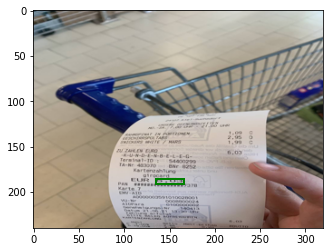

In [208]:
images = []
bboxes = []
for idx, row in annotations.iterrows():
    path = os.path.join(IMAGES, row["file_name"])
    image = np.array(tf.keras.preprocessing.image.load_img(path, target_size=TARGETDIMS, interpolation="bicubic"))
    bbox = np.array(row["bbox"]) / np.array(BBOX_SCALING_FACTORS)
    images.append(image)
    bboxes.append(bbox)

images = np.array(images)
bboxes = np.array(bboxes)
    
def display_image_bbox(image, test_bbox=None, train_bbox=None):
    plt.figure()
    plt.imshow(image)
    if not test_bbox is None:
        plt.gca().add_patch(Rectangle((test_bbox[0] * TARGETDIMS[1],test_bbox[1] * TARGETDIMS[0]), test_bbox[2] * TARGETDIMS[1], test_bbox[3] * TARGETDIMS[0], edgecolor="red", facecolor="none", lw=2))
    if not train_bbox is None:
        plt.gca().add_patch(Rectangle((train_bbox[0] * TARGETDIMS[1],train_bbox[1] * TARGETDIMS[0]), train_bbox[2] * TARGETDIMS[1], train_bbox[3] * TARGETDIMS[0], edgecolor="green", facecolor="none", lw=2))
    plt.show()

display("Loaded " + str(len(images)) + " images and " + str(len(bboxes)) + " bboxes")
    
display_image_bbox(images[10], train_bbox=bboxes[10])

In [149]:
images.shape

(29, 240, 320, 3)

In [187]:
import tensorflow.keras.layers as K
model = tf.keras.Sequential()
model.add(K.InputLayer((TARGETDIMS[0], TARGETDIMS[1], 3)))
for i in range(4):
    model.add(K.Conv2D(filters=2**(min(i,4) + 6), kernel_size=(3,3), activation="relu"))
    model.add(K.Conv2D(filters=2**(min(i,4) + 6), kernel_size=(3,3), activation="relu"))
    model.add(K.MaxPool2D(pool_size=(2,2)))
model.add(K.Flatten())
model.add(K.Dense(4))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_62 (Conv2D)           (None, 238, 318, 64)      1792      
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 236, 316, 64)      36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 118, 158, 64)      0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 116, 156, 128)     73856     
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 114, 154, 128)     147584    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 57, 77, 128)       0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 55, 75, 256)     

In [188]:
#from https://github.com/ForeverStrongCheng/intersection_over_union-python/blob/master/intersection_over_union.py
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

def convert_xywh_to_corners(xywh):
    return np.array([xywh[0], xywh[1], xywh[2] + xywh[0], xywh[3] + xywh[1]])

def iou(bboxA, bboxB):
    np_A = np.array(bboxA[0])
    np_B = np.array(bboxB[0])
    #print(np_A)
    return bb_intersection_over_union(convert_xywh_to_corners(np_A), convert_xywh_to_corners(np_B))

In [191]:
def iou_metric(ytrue, ypred):
    return tf.py_function(iou, inp=[ytrue, ypred], Tout=tf.float32)
    

imagedata = tf.data.Dataset.from_tensor_slices((images, bboxes)).repeat(10)
    
model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error', iou_metric])
model.fit(images, bboxes, batch_size=29, epochs=20, steps_per_epoch=1, validation_split=0.1)

Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 7.1102e-04 - mean_squared_error: 7.1102e-04 - iou_metric: 0.9528 - val_loss: 70.6991 - val_mean_squared_error: 70.6991 - val_iou_metric: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 484ms/step - loss: 67.2326 - mean_squared_error: 67.2326 - iou_metric: 0.0000e+00 - val_loss: 0.3916 - val_mean_squared_error: 0.3916 - val_iou_metric: 0.0018
Epoch 3/20
1/1 [==============================] - 0s 496ms/step - loss: 0.3208 - mean_squared_error: 0.3208 - iou_metric: 0.0755 - val_loss: 0.1244 - val_mean_squared_error: 0.1244 - val_iou_metric: 0.3658
Epoch 4/20
1/1 [==============================] - 0s 481ms/step - loss: 0.0916 - mean_squared_error: 0.0916 - iou_metric: 0.6354 - val_loss: 0.2772 - val_mean_squared_error: 0.2772 - val_iou_metric: 0.2020
Epoch 5/20
1/1 [==============================] - 0s 482ms/step - loss: 0.2591 - mean_squared_error: 0.2591 - iou_metric: 0.1418 - val_loss: 0.1384 - val_mean_

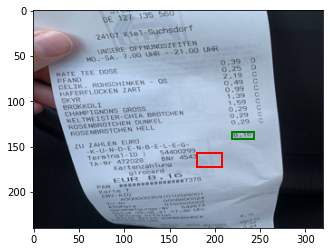

In [222]:
test_image = 11
tfimg = np.array([images[test_image]])
bbox = model.predict(tfimg)[0]
display_image_bbox(images[test_image], train_bbox=bboxes[test_image], test_bbox=bbox)

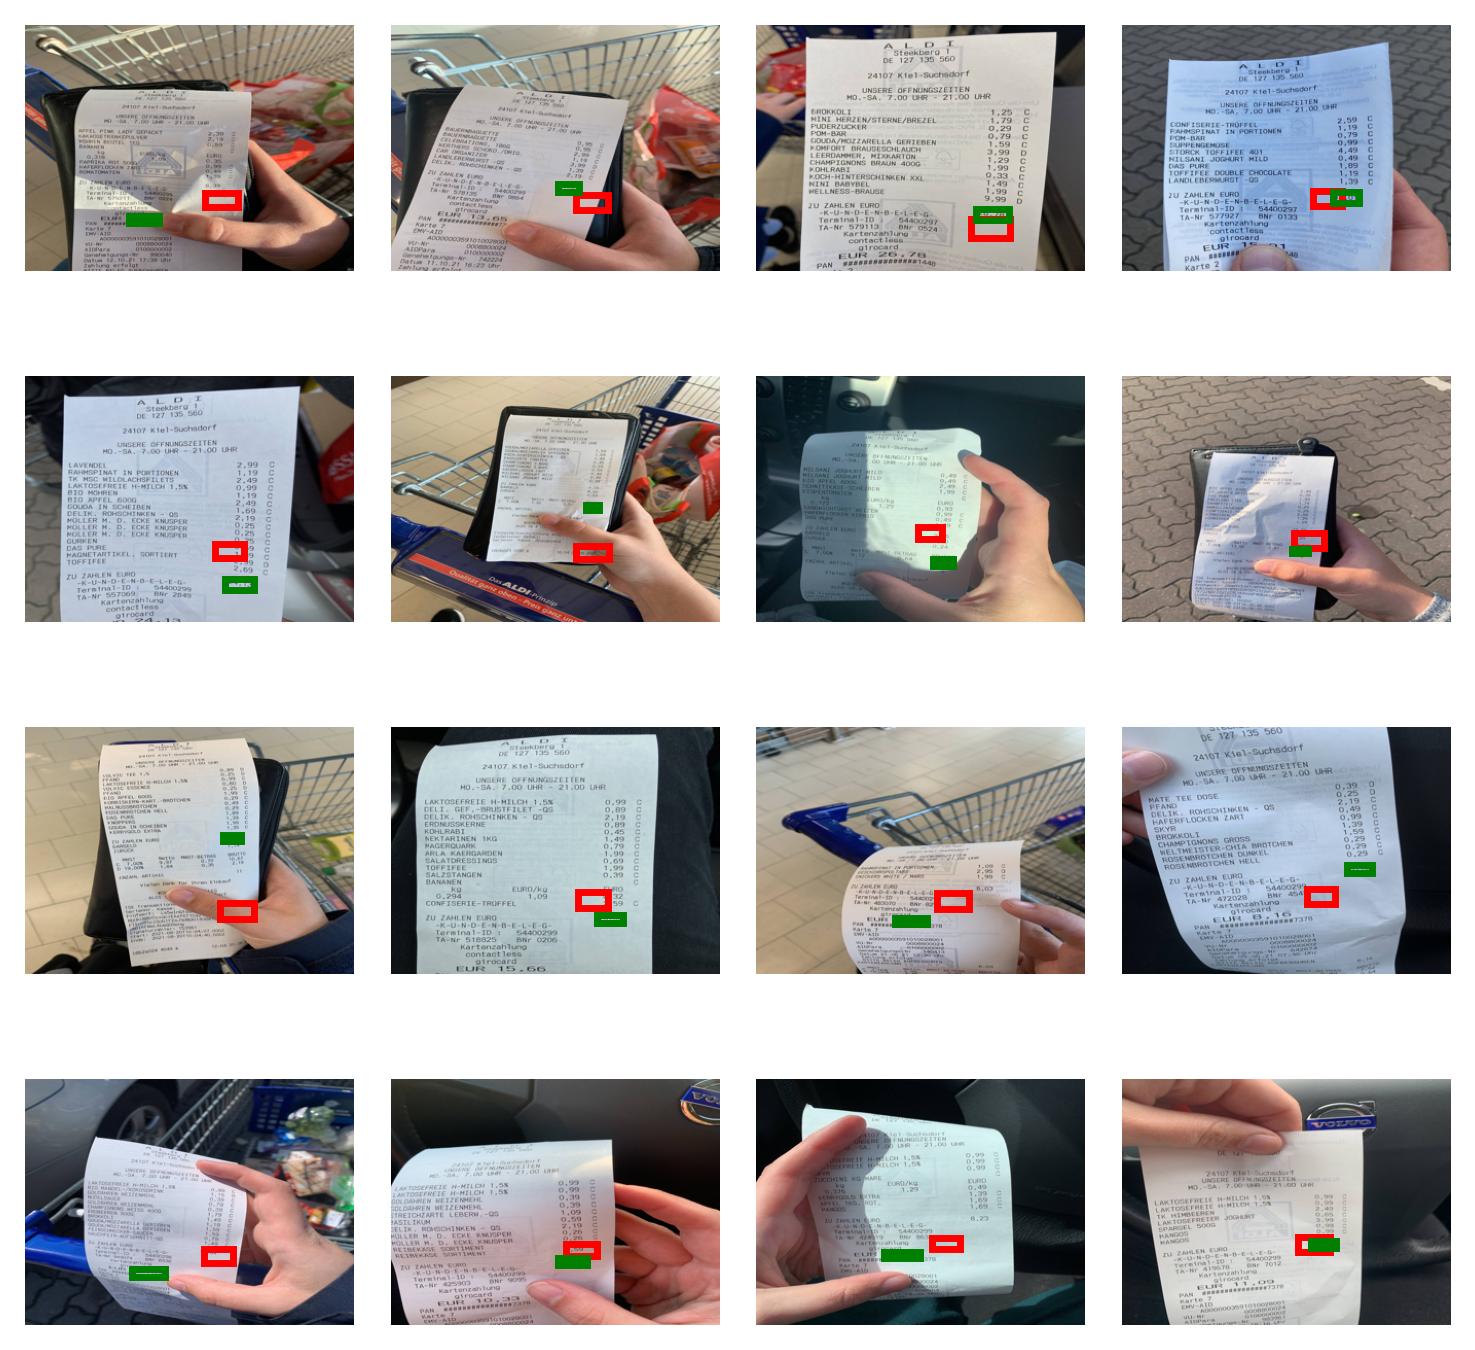

In [236]:
fig, axs = plt.subplots(4,4, figsize=(6,6), dpi=250)
for y in range(4):
    for x in range(4):
        image_number = y * 4 + x;
        image = images[image_number]
        axs[(y,x)].imshow(image)
        train_bbox = bboxes[image_number]
        tfimg = np.array([image])
        test_bbox = model.predict(tfimg)[0]
        axs[(y,x)].add_patch(Rectangle((test_bbox[0] * TARGETDIMS[1],test_bbox[1] * TARGETDIMS[0]), test_bbox[2] * TARGETDIMS[1], test_bbox[3] * TARGETDIMS[0], edgecolor="red", facecolor="none", lw=2))
        axs[(y,x)].add_patch(Rectangle((train_bbox[0] * TARGETDIMS[1],train_bbox[1] * TARGETDIMS[0]), train_bbox[2] * TARGETDIMS[1], train_bbox[3] * TARGETDIMS[0], edgecolor="green", facecolor="none", lw=2))
        axs[(y,x)].axis("off")
plt.tight_layout()
plt.show() 